 Full Proposed Project Pipeline: Hybrid QPCA + Classical ML

🧩 1. Problem Definition
- Research Question: Can quantum techniques (specifically QPCA) improve the efficiency or performance of feature extraction in high-dimensional datasets within classical ML pipelines?

- Hypothesis: A hybrid quantum-classical architecture may offer benefits in dimensionality reduction efficiency, especially with unsorted, high-dimensional data.

 2. Synthetic Dataset Generation
- Use sklearn.datasets.make_classification() to simulate a high-dimensional classification problem.

- Example: n_samples=1000, n_features=20, n_informative=15, n_classes=2

- Split into train/test sets.

In [ ]:
# Imports 

import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
# Synthetic Dataset Generation
# Set seed for reproducibility
np.random.seed(42)

# Generate synthetic high-dimensional dataset
X, y = make_classification(n_samples=1000,
                           n_features=40,
                           n_informative=30,
                           n_redundant=5,
                           n_classes=2,
                           shuffle=True,
                           random_state=42)

print(f"Data shape: {X.shape}")

Data shape: (1000, 40)


In [19]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
    )

# Normalize the data (important for quantum encoding)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Show a preview
df_preview = pd.DataFrame(X_train_scaled[:5], columns=[f'feature_{i+1}' for i in range(X.shape[1])])
df_preview['label'] = y_train[:5]
print("Sample of training data:")
print(df_preview)

Sample of training data:
   feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0  -0.698002   0.905045   0.210736  -0.879909  -0.215176   0.862068   
1  -1.706684  -0.168339   2.238924  -0.959698   0.664207   0.424639   
2  -0.330593  -0.734315   2.041501   0.992453  -0.343587   2.988228   
3  -0.753068  -0.332605   0.566178  -0.672696  -1.934889   0.512409   
4  -1.544184  -0.536237   0.901722   1.139381   0.852211   1.577609   

   feature_7  feature_8  feature_9  feature_10  ...  feature_32  feature_33  \
0   0.057933   1.249031   1.328745    0.998179  ...    1.315572   -0.571991   
1   0.600736  -0.121748   0.304359    0.213885  ...    0.972665    1.679978   
2  -0.039906   1.334040   0.418727    0.821001  ...   -0.712096    0.313850   
3   1.564845  -0.500113  -1.425344    0.611519  ...   -2.453925    0.612348   
4   0.577226   0.018169   0.284733    0.789510  ...   -1.073354   -0.243648   

   feature_34  feature_35  feature_36  feature_37  feature_38  feature_39

## Classical PCA Pipeline

In [20]:
from sklearn.decomposition import PCA

# STEP 6: Fit PCA on training data
pca = PCA()
X_train_pca_full = pca.fit_transform(X_train_scaled)

# STEP 7: Calculate explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# STEP 8: Find number of components to retain 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of PCA components to retain 95% variance: {n_components_95}")

Number of PCA components to retain 95% variance: 30


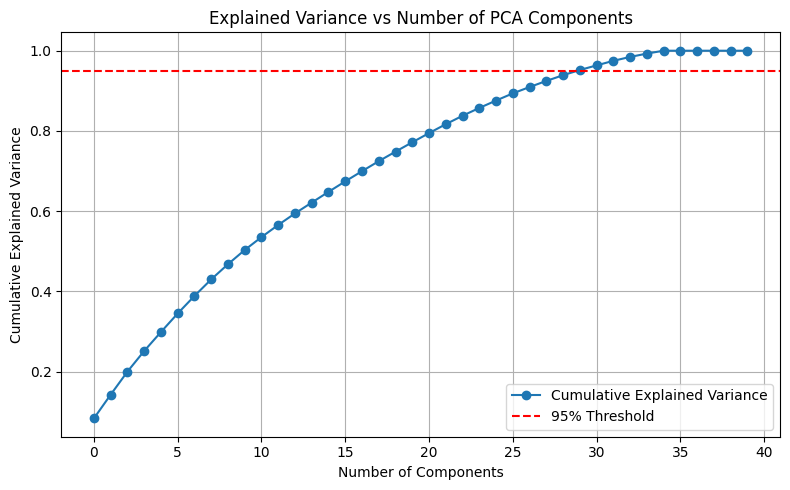

In [21]:
# STEP 9: Visualize cumulative variance
plt.figure(figsize=(8, 5))
plt.plot(cumulative_variance, marker='o', label='Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
plt.title('Explained Variance vs Number of PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Train a Classifier on PCA-Reduced Features (Baseline Model)

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report

# ✅ STEP 10: Reduce both train and test sets using optimal number of components
pca = PCA(n_components=n_components_95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# ✅ STEP 11: Train a Logistic Regression model (you can also use SVM or XGBoost later)
clf_pca = LogisticRegression(max_iter=1000, random_state=42)
clf_pca.fit(X_train_pca, y_train)

# ✅ STEP 12: Predict and evaluate
y_pred_pca = clf_pca.predict(X_test_pca)

accuracy_pca = accuracy_score(y_test, y_pred_pca)
f1_pca = f1_score(y_test, y_pred_pca)

In [23]:
print(f"\n Classical PCA + Logistic Regression Results:")
print(f"Accuracy: {accuracy_pca:.4f}")
print(f"F1 Score: {f1_pca:.4f}")
print("\nDetailed classification report:")
print(classification_report(y_test, y_pred_pca))



 Classical PCA + Logistic Regression Results:
Accuracy: 0.7500
F1 Score: 0.7340

Detailed classification report:
              precision    recall  f1-score   support

           0       0.80      0.73      0.76       111
           1       0.70      0.78      0.73        89

    accuracy                           0.75       200
   macro avg       0.75      0.75      0.75       200
weighted avg       0.76      0.75      0.75       200



## Quantum PCA Pipeline (Hybrid)

In [7]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import ZZFeatureMap
from numpy import linalg as LA

Simulate Quantum States for QPCA

    Creating the feature-encoded quantum circuit for each sample

    Simulating each circuit using the AerSimulator to get the statevectors

    Collecting these vectors for QPCA

### Try with 5/10/20 features.

In [55]:
# Setup
num_qubits = 10  # 2^5 = 32-dim Hilbert space
X_train_qpca = X_train_scaled[:, :num_qubits]
X_test_qpca = X_test_scaled[:, :num_qubits]

In [56]:
# Feature Map: encodes classical features into quantum circuits
feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=2, entanglement='linear')

# Quantum Simulator Backend
simulator = AerSimulator(method='statevector')

# Simulate quantum circuits to get statevectors
statevectors = []
num_samples_for_qpca = 500  # Keep small for simulation speed

for i in range(num_samples_for_qpca):
    qc = QuantumCircuit(num_qubits)
    
    # Bind parameters of the feature map to the sample's features
    feature_params = dict(zip(feature_map.parameters, X_train_qpca[i]))
    bound_circuit = feature_map.assign_parameters(feature_params)
    qc.compose(bound_circuit, inplace=True)

    
    # Transpile and simulate
    transpiled_qc = transpile(qc, simulator)
    state = Statevector.from_instruction(transpiled_qc)
    
    # Store the statevector
    statevectors.append(state.data)

# Convert list of statevectors to matrix
state_matrix = np.array(statevectors)

# Output shape
print("Quantum state matrix shape:", state_matrix.shape)

Quantum state matrix shape: (500, 1024)


Step 14: Perform Quantum PCA (QPCA) Simulation

2.4 – Code for QPCA Simulation

In [41]:
# Compute density matrix: ρ = (1/N) Σ |ψ⟩⟨ψ|
# Each |ψ⟩ is a statevector (complex vector), and |ψ⟩⟨ψ| is its outer product
rho = np.zeros((2**num_qubits, 2**num_qubits), dtype=complex)

for state in state_matrix:
    rho += np.outer(state, np.conj(state))  # |ψ⟩⟨ψ|

rho = rho / len(state_matrix)  # Normalize

# Eigen decomposition of the density matrix (quantum analog of PCA)
eig_vals, eig_vecs = LA.eigh(rho)

# Sort eigenvalues and eigenvectors in descending order
sorted_indices = np.argsort(eig_vals)[::-1]
eig_vals_sorted = eig_vals[sorted_indices]
eig_vecs_sorted = eig_vecs[:, sorted_indices]

# Show top eigenvalues (principal components)
print("Top eigenvalues:", eig_vals_sorted[:5])

Top eigenvalues: [0.01000367 0.00806209 0.00760137 0.00745965 0.00713247]


In [42]:
# Explained Variance
explained_variance_ratio = eig_vals_sorted / np.sum(eig_vals_sorted)
cumulative_variance = np.cumsum(explained_variance_ratio)

# Determine components to retain 95% variance
n_components_qpca = np.argmax(cumulative_variance >= 0.95) + 1
print(f"QPCA: Components to retain 95% variance: {n_components_qpca}")

QPCA: Components to retain 95% variance: 377


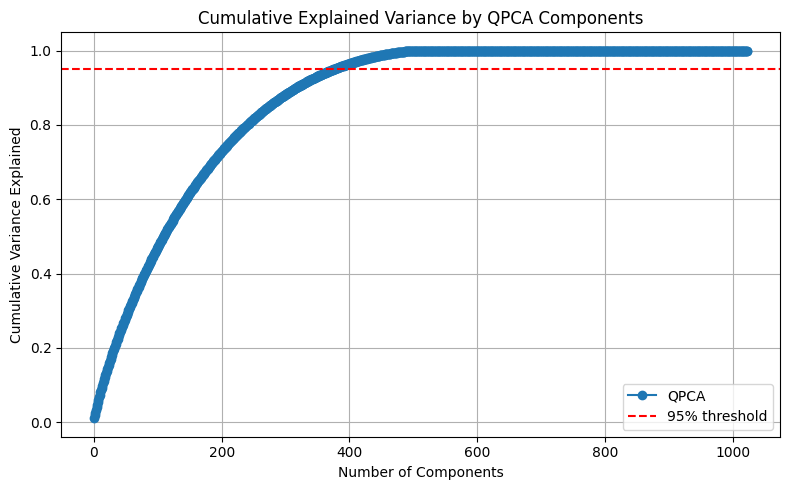

In [43]:
# Plot Cumulative Explained Variance
plt.figure(figsize=(8, 5))
plt.plot(cumulative_variance, marker='o', label='QPCA')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
plt.title('Cumulative Explained Variance by QPCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Project to QPCA Feature Space

In [44]:
# Project quantum statevectors to reduced QPCA feature space
top_eigvecs = eig_vecs_sorted[:, :n_components_qpca]  # shape: (32, 29)
X_train_qpca_reduced = state_matrix @ top_eigvecs     # shape: (500, 29)

print("QPCA-reduced feature matrix shape:", X_train_qpca_reduced.shape)


QPCA-reduced feature matrix shape: (500, 377)


Train Classifier on QPCA Features

In [45]:
#  Import classifier tools
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Convert complex values to real for compatibility with sklearn
X_train_qpca_real = X_train_qpca_reduced.real

# Train model on QPCA-reduced training features
clf_qpca = LogisticRegression(max_iter=1000, random_state=42)
clf_qpca.fit(X_train_qpca_real, y_train[:len(X_train_qpca_real)])

# Predict and evaluate
y_pred_qpca = clf_qpca.predict(X_train_qpca_real)

# Evaluate
accuracy_qpca = accuracy_score(y_train[:len(y_pred_qpca)], y_pred_qpca)
f1_qpca = f1_score(y_train[:len(y_pred_qpca)], y_pred_qpca)


In [46]:
print(f"\n QPCA + Logistic Regression Results (Train Only):")
print(f"Accuracy: {accuracy_qpca:.4f}")
print(f"F1 Score: {f1_qpca:.4f}")
print("\nDetailed classification report:")
print(classification_report(y_train[:len(y_pred_qpca)], y_pred_qpca))


 QPCA + Logistic Regression Results (Train Only):
Accuracy: 0.7820
F1 Score: 0.7993

Detailed classification report:
              precision    recall  f1-score   support

           0       0.82      0.71      0.76       245
           1       0.75      0.85      0.80       255

    accuracy                           0.78       500
   macro avg       0.79      0.78      0.78       500
weighted avg       0.79      0.78      0.78       500



Step 17: Encode & Project the Test Set Using QPCA

In [47]:
# STEP 17.1: Encode the test set using the same feature map
X_test_qpca_input = X_test_scaled[:, :num_qubits]
test_statevectors = []

for i in range(len(X_test_qpca_input)):
    qc = QuantumCircuit(num_qubits)
    feature_params = dict(zip(feature_map.parameters, X_test_qpca_input[i]))
    bound_circuit = feature_map.assign_parameters(feature_params)
    qc.compose(bound_circuit, inplace=True)
    transpiled = transpile(qc, simulator)
    state = Statevector.from_instruction(transpiled)
    test_statevectors.append(state.data)

test_state_matrix = np.array(test_statevectors)

# STEP 17.2: Project test statevectors using the same eigenvectors
X_test_qpca_reduced = test_state_matrix @ top_eigvecs
X_test_qpca_real = X_test_qpca_reduced.real


 Step 18: Final Evaluation on QPCA Test Set

In [48]:
# STEP 18: Evaluate QPCA model on test set
y_pred_qpca_test = clf_qpca.predict(X_test_qpca_real)

accuracy_qpca_test = accuracy_score(y_test, y_pred_qpca_test)
f1_qpca_test = f1_score(y_test, y_pred_qpca_test)

print(f"\n📊 QPCA + Logistic Regression Results (Test Set):")
print(f"Accuracy: {accuracy_qpca_test:.4f}")
print(f"F1 Score: {f1_qpca_test:.4f}")
print("\nDetailed classification report:")
print(classification_report(y_test, y_pred_qpca_test))



📊 QPCA + Logistic Regression Results (Test Set):
Accuracy: 0.4600
F1 Score: 0.4953

Detailed classification report:
              precision    recall  f1-score   support

           0       0.52      0.35      0.42       111
           1       0.42      0.60      0.50        89

    accuracy                           0.46       200
   macro avg       0.47      0.47      0.46       200
weighted avg       0.48      0.46      0.45       200



### Feature Grouping Strategy, which lets you use all 40 features by splitting them into 8 groups of 5, applying QPCA to each group, then concatenating the reduced representations.



In [ ]:
num_qubits = 5
group_size = 5
num_groups = X_train_scaled.shape[1] // group_size
num_samples = 100  # to keep simulation fast
k_components_per_group = 3  # change as you want (2–4 is fine)

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import ZZFeatureMap
from numpy.linalg import eigh

simulator = AerSimulator(method='statevector')
feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=1, entanglement='linear')

qpca_features_list = []

for g in range(num_groups):
    print(f"🔹 Processing Group {g+1}/{num_groups}...")
    start = g * group_size
    end = (g + 1) * group_size
    X_group = X_train_scaled[:num_samples, start:end]

    # Encode and simulate
    statevectors = []
    for i in range(num_samples):
        qc = QuantumCircuit(num_qubits)
        params = dict(zip(feature_map.parameters, X_group[i]))
        qc.compose(feature_map.assign_parameters(params), inplace=True)
        transpiled = transpile(qc, simulator)
        state = Statevector.from_instruction(transpiled)
        statevectors.append(state.data)

    state_matrix = np.array(statevectors)

    # Density matrix and QPCA
    rho = sum(np.outer(ψ, ψ.conj()) for ψ in state_matrix) / len(state_matrix)
    eigvals, eigvecs = eigh(rho)
    sorted_indices = np.argsort(eigvals)[::-1]
    top_vecs = eigvecs[:, sorted_indices[:k_components_per_group]]

    # Project and extract real part
    projected = state_matrix @ top_vecs
    real_features = projected.real
    qpca_features_list.append(real_features)


# Final QPCA feature matrix using all 40 features
X_train_qpca_all = np.hstack(qpca_features_list)
print("Final QPCA-reduced feature shape:", X_train_qpca_all.shape)

🧼 3. Data Preprocessing
- StandardScaler or MinMaxScaler for normalization (required for quantum encoding).

- Optional: introduce noise or shuffle feature columns to simulate unsorted data.

- Store a copy of the data pre- and post-quantum processing for comparison.

⚛️ 4. Quantum Feature Pipeline: Quantum PCA (QPCA)

a. Data Encoding to Quantum State

- Use ZZFeatureMap or PauliFeatureMap (as in the reference code).

- Limit dimensions (e.g., 4-8 features) due to simulator constraints.

- Use amplitude or angle encoding depending on QPCA requirements.

b. Quantum Covariance Matrix Simulation
- Compute a density matrix representation of the data via Qiskit’s statevector simulator.

- Estimate principal components using Qiskit’s methods (see below).

- Use qiskit.algorithms.QPCA or implement the logic manually if needed.

c. Projection & Extraction
- Project quantum-transformed data into lower-dimensional classical space.

- Output transformed feature matrix (e.g., reduce from 8D → 2D).

🧠 5. Classical Training Pipeline
- Train ML models before and after quantum transformation:

- Baseline: Train on original high-dimensional features.

- QPCA Output: Train on reduced-dimensional features.

Models to use:

- Logistic Regression

- SVM

- XGBoost

📊 6. Evaluation Metrics
- Accuracy, F1-score

- Dimensionality reduction performance (variance explained)

- Training time / inference time

- Visualization:

    - 2D PCA scatterplots

    - Heatmaps of covariance matrices (quantum vs. classical)

🔁 7. Ablation & Sensitivity Testing (Optional)
- Vary number of qubits/features (e.g., 4, 6, 8)

- Add noise to inputs to test robustness

- Compare runtime scaling with increased dimensionality



🧪 8. Benchmarking vs. Classical PCA
- Apply sklearn.decomposition.PCA on the same dataset

- Compare with QPCA on:

    - Runtime

    - Explained variance

    - Model accuracy after reduction



📚 9. Documentation & Report Structure
Sections:

Introduction & Motivation

Background (Classical PCA vs. QPCA)

Quantum Computing Concepts

Hybrid Architecture Design

Implementation (with Qiskit + Python code)

Results & Evaluation

Conclusions & Future Work

⚙️ 10. Tech Stack
- Qiskit (quantum circuits, QPCA, simulators)

- NumPy, scikit-learn, matplotlib, seaborn

- Optional: Jupyter Notebooks + Streamlit dashboard

